### Download & Define Model, Tokenizer and librispeech_test dataset


In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import torchaudio
from torch.utils.data import DataLoader

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")

librispeech_test = torchaudio.datasets.LIBRISPEECH(".", url="test-clean", download=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are

#### Install necessities for defining functions

In [ ]:
!pip install pyrubberband
!pip install torch-time-stretch

### Defining read audio and other distortion functions


In [ ]:
import os
from scipy import signal
import pyrubberband as pyrb
import torch
import torchaudio
import torchaudio.transforms as T
from torch_time_stretch import time_stretch
import numpy as np
# import shutil
import tempfile
import subprocess
import soundfile as sf

def read_audio(filepath, fs=16000,  mono=True, normalize=False, preemphasis=False):
    """
    Reads audio file stored at <filepath>
    Parameters:
        filepath (str): audio file path
        fs (int, optional): samping rate
        mono (boolean, optional): return single channel
        normalize(boolean, optional): peak normalization of signal
        preemphasis (boolean, optional): apply pre-emphasis filter
    Returns:
        waveform (tensor): audio signal, dim(N,)
    """
    assert isinstance(filepath, str), "filepath must be specified as string"
    assert os.path.exists(filepath), f"{filepath} does not exist."

    try:
        waveform, sr = torchaudio.load(filepath)
        # mono channel
        if waveform.shape[0] == 2 and mono is True: waveform = waveform[0]
        else: waveform = waveform.reshape(-1)
        # preemphasis
        if preemphasis:
            waveform = pre_emphasis(waveform)
        # resample
        if sr != fs:
            resampler = T.Resample(sr, fs, dtype=waveform.dtype)
            waveform = resampler(waveform)
        # normalize
        if normalize:
            waveform = rms_normalize(waveform)
        return waveform
    except Exception as e:
        return None


def peak_normalize(waveform):
    """
    Peak normalizes the <waveform>
    Parameter:
        waveform (tensor): waveform, dims: (N,)
    """
    return waveform/torch.max(torch.abs(waveform))


def rms_normalize(waveform, r=-10):
    """
    RMS-normalization of  <waveform>
    Parameter:
        waveform (tensor): waveform, dims: (N,)
        rms (float): rms in dB
    """
    current_rms = torch.pow(torch.mean(torch.pow(waveform,2)) ,0.5)
    scaling_factor = (10**(r/10))/current_rms
    return waveform*scaling_factor


def pre_emphasis(waveform, coeff=0.97):
    filtered_sig = torch.empty_like(waveform)
    filtered_sig[1:] = waveform[1:] - coeff*waveform[:-1]
    filtered_sig[0] = waveform[0]
    return filtered_sig


def add_time_stretch(audio, fs, stretch_rate):
    """
    Adds time stretch to <clean> audio by <stretch_rate> factor.
    Parameters:
        audio (tensor): waveform, dims: (N,)
        fs (float): audio sample rate
        stretch_rate (float): playback rate
    Returns:
        audio_stretch (tensor): time stretched waveform dims: (N*<stretch_rate>,)

    """
    audio_stretch = time_stretch(audio.unsqueeze(0).unsqueeze(0), 1/stretch_rate, fs)
    # assert len(audio)/stretch_rate == len(audio_stretch), f"stretched audio length mismatch. Expected {len(audio)*stretch_rate}, got {len(audio_stretch)}"
    return audio_stretch.squeeze_()


def add_pitch_shift_rb(y, sr, shift, tmpdir=None):
    """
    Adds pitch shift to <y> audio sampled at <sr> by <shift> semitones. It calls rubberband package directly; does not use pyrubberband package.
    """
    if isinstance(y, np.ndarray) is False:
        y = y.numpy()

    if tmpdir is not None:
        tempfile.tempdir = tmpdir

    # Get the input and output tempfile
    fd, infile = tempfile.mkstemp(suffix='.wav')
    os.close(fd)
    fd, outfile = tempfile.mkstemp(suffix='.wav')
    os.close(fd)

    sf.write(infile, y, sr)
    command = ["rubberband", "-q", "--pitch", str(shift), infile, outfile]
    subprocess.run(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    y_out, _ = sf.read(outfile, always_2d=True, dtype=y.dtype)
    if y.ndim == 1:
        y_out = np.squeeze(y_out)

    os.unlink(infile)
    os.unlink(outfile)
    return torch.from_numpy(y_out).type(torch.float32)


def add_pitch_shift(audio, fs, semitone_shift, use_rb=True):
    """
    Adds pitch shift to <clean> audio by <semitone_shit> semitones.
    Parameters:
        audio (tensor): clean waveform, dims: (N,)
        fs (float): audio sample rate
        semitone_shift (float): semitones (can be between -12 and 12, but keep it low for good sound quality)
    Returns:
        audio_shift: pitch shifted added signal (tensor), dims: (N,)

    """
    if use_rb:
        audio_shift = pyrb.pitch_shift(audio.numpy(), fs, semitone_shift)
        return torch.from_numpy(audio_shift).type(torch.float32)
    else:
        audio_shift = torchaudio.functional.pitch_shift(audio, fs, semitone_shift)
        return audio_shift

def add_noise(audio, noise, snr):
    """
    Adds background <noise> to <clean> signal at desired <SNR> level
    Parameters:
        audio (tensor): clean waveform, dims: (N,)
        noise (tensor): noise waveform, dims: (M,)
        snr (int): SNR level in dB
    Returns:
        noisy_audio: noisy signal (tensor), dims: (N,)
    """
    # make equal lengths for clean and noise signals
    if len(audio) >= len(noise):
        reps = torch.ceil(torch.tensor(len(audio)/len(noise))).int()
        noise = torch.tile(noise, (reps,))[:len(audio)]
    else:
        start_idx = torch.randint(len(noise) - len(audio), (1,))
        noise = noise[start_idx:start_idx+len(audio)]

    assert len(noise) == len(audio), f"noise signal {len(noise)} and clean signal {len(audio)} length mismatch"

    # add noise at desired snr
    audio_rms = torch.mean(torch.pow(audio, 2))
    noise_rms = torch.mean(torch.pow(noise, 2))
    factor = torch.pow((audio_rms/noise_rms)/torch.pow(torch.tensor(10), (snr/10)), 0.5)
    noise = factor*noise
    noisy_audio = audio + noise
    assert 10*torch.log10(audio_rms/torch.mean(torch.pow(noise, 2))) - snr < 1e-4, f"snr mismatch {10*torch.log10(audio_rms/torch.mean(torch.pow(noise, 2))), snr, len(audio), len(noise), audio_rms, torch.mean(torch.pow(noise, 2)), noise_rms, factor, audio, torch.count_nonzero(audio)}"
    return noisy_audio


def add_reverb(clean, rir):
    """
    Filters <clean> signal with <rir> to get reverberation effect
    Parameters:
        clean (tensor): clean waveform, dims: (N,)
        rir (tensor): room impulse response, dims: (M,)
    Returns:
        reverb added signal (tensor), dims: (N,)
    """
    clean = clean.numpy()
    rir = rir.numpy()
    rir = rir/np.linalg.norm(rir)
    # filering
    p_max = np.argmax(np.abs(rir))
    filtered_clean = signal.convolve(clean, rir, mode="full")

    # time offset
    e = np.empty_like(filtered_clean, dtype=np.float32)
    e[-p_max:] = 0.0
    e[:-p_max] = filtered_clean[p_max:]
    # filtered_clean = e.copy()
    # e=None
    filtered_clean = e[:len(clean)]
    assert(len(filtered_clean)==len(clean))
    filtered_clean = torch.from_numpy(filtered_clean)
    return filtered_clean


def add_noise_reverb(audio, noise, snr, rir):
    """
    Adds background <noise> at desired <snr> level and reveberation using <rir> to <clean> signal
    Parameters:
        audio (tensor): clean waveform, dims: (N,)
        noise (tensor): noise waveform, dims: (M,)
        snr (int): SNR level in dB
        rir (tensor): room impulse response, dims: (M,)
    Returns:
        noise and reverb added signal (tensor), dims: (N,)
    """
    audio_reverb = add_reverb(audio, rir)
    noise_reverb = add_reverb(noise, rir)
    noise_reverb_clean = add_noise(audio_reverb, noise_reverb, snr)
    return noise_reverb_clean

#### Function to tokenize audio using Wav2Vec2 model and tokenizer

In [ ]:
def transcribe_audio(audio):
    input_values = tokenizer(audio.numpy(), return_tensors="pt").input_values
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    return predicted_ids

#### Funtion to calcualte percentage of the changed tokens

In [ ]:
import torch
import glob

# Simplified function to compare transcripts
def compare_transcripts(original_tokens, distorted_tokens):
    total_tokens = len(original_tokens)
    num_differences = sum(1 for orig, distorted in zip(original_tokens, distorted_tokens) if orig != distorted)
    percentage_changed = (num_differences / total_tokens) * 100 if total_tokens > 0 else 0
    num_noisy_tokens = len(distorted_tokens)  # Number of tokens in the distorted (noisy) transcript
    return percentage_changed, total_tokens, num_differences, num_noisy_tokens

# Read paths of all flac files in the directory
flac_files = glob.glob("/content/LibriSpeech/test-clean/**/*.flac", recursive=True)

In [ ]:
clean_audio = read_audio("/content/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac")
noise_audio = read_audio("/content/Traffic.wav")

In [ ]:
# Select the first 1000 files
flac_files_subset = flac_files[:10]

print(flac_files_subset)

# Initialize dictionaries to store the total number of tokens and the number of changed tokens for each SNR
snr_token_counts = {0: 0, 5: 0, 10: 0, 15: 0, 20: 0, 25: 0}
snr_changed_token_counts = {0: 0, 5: 0, 10: 0, 15: 0, 20: 0, 25: 0}
snr_noisy_token_counts = {0: 0, 5: 0, 10: 0, 15: 0, 20: 0, 25: 0}
average_percentage_changed_snr = {0: 0, 5: 0, 10: 0, 15: 0, 20: 0, 25: 0}

# Loop over SNR values 10, 15, 20, and 25
for snr in [0, 5, 10, 15, 20, 25]:
    print(f"\n--- SNR {snr} ---")

    total_percentage_changed = 0  # Initialize total percentage changed for this SNR

    # Loop over audio files
    for file_path in flac_files_subset:
        # Read clean audio
        clean_audio = read_audio(file_path)

        # Add noise to clean audio
        noisy_audio = add_noise(clean_audio, noise_audio, snr)

        # Transcribe clean and noisy audio
        predicted_ids_clean = transcribe_audio(clean_audio)
        predicted_ids_noisy = transcribe_audio(noisy_audio)

        # Compare transcripts using the simplified function
        percentage_changed, total_tokens, num_differences, num_noisy_tokens = compare_transcripts(predicted_ids_clean.squeeze().numpy(), predicted_ids_noisy.squeeze().numpy())

        # Update total token count for this SNR
        snr_token_counts[snr] += total_tokens

        # Update total changed token count for this SNR
        snr_changed_token_counts[snr] += num_differences

        # Update total noisy token count for this SNR
        snr_noisy_token_counts[snr] += num_noisy_tokens

        # Print total number of clean tokens, number of tokens changed, percentage of tokens changed, and number of noisy tokens
        print(f"File: {file_path.split('/')[-1]}, Total clean tokens: {total_tokens}, Tokens changed: {num_differences}, Percentage changed: {percentage_changed:.2f}%, Noisy tokens: {num_noisy_tokens}")

    # Calculate the average percentage of tokens changed for this SNR
    average_percentage_changed_snr[snr] = (snr_changed_token_counts[snr] / snr_token_counts[snr]) * 100

    # Print the average percentage of tokens changed for this SNR
    print(f"Average percentage of tokens changed for SNR {snr}: {average_percentage_changed_snr[snr]:.2f}%")

['/content/LibriSpeech/test-clean/121/123859/121-123859-0003.flac', '/content/LibriSpeech/test-clean/121/123859/121-123859-0001.flac', '/content/LibriSpeech/test-clean/121/123859/121-123859-0002.flac', '/content/LibriSpeech/test-clean/121/123859/121-123859-0000.flac', '/content/LibriSpeech/test-clean/121/123859/121-123859-0004.flac', '/content/LibriSpeech/test-clean/121/127105/121-127105-0021.flac', '/content/LibriSpeech/test-clean/121/127105/121-127105-0006.flac', '/content/LibriSpeech/test-clean/121/127105/121-127105-0009.flac', '/content/LibriSpeech/test-clean/121/127105/121-127105-0008.flac', '/content/LibriSpeech/test-clean/121/127105/121-127105-0029.flac']

--- SNR 0 ---
File: 121-123859-0003.flac, Total clean tokens: 541, Tokens changed: 54, Percentage changed: 9.98%, Noisy tokens: 541
File: 121-123859-0001.flac, Total clean tokens: 1269, Tokens changed: 152, Percentage changed: 11.98%, Noisy tokens: 1269
File: 121-123859-0002.flac, Total clean tokens: 1501, Tokens changed: 214,

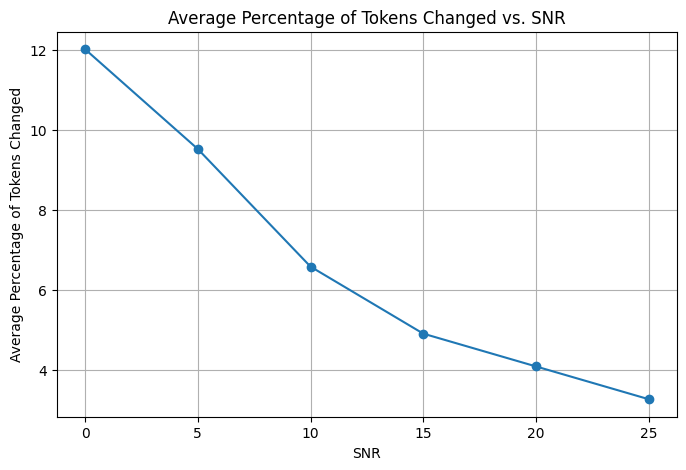

In [ ]:
import matplotlib.pyplot as plt

# SNR values and average percentages
snr_values = list(average_percentage_changed_snr.keys())
average_percentages = [average_percentage_changed_snr[snr] for snr in snr_values]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(snr_values, average_percentages, marker='o', linestyle='-')
plt.title('Average Percentage of Tokens Changed vs. SNR')
plt.xlabel('SNR')
plt.ylabel('Average Percentage of Tokens Changed')
plt.grid(True)
plt.xticks(snr_values)
plt.show()

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

print(flac_files_subsets)

['/content/LibriSpeech/test-clean/121/121726/121-121726-0001.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0014.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0011.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0000.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0008.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0006.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0003.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0005.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0013.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0004.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0009.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0002.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0010.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0007.flac', '/content/LibriSpeech/test-clean/121/121726/121-121726-0012.f

In [ ]:
def process_single_snr(snr):
    print(f"\n--- SNR {snr} ---")

    total_percentage_changed = 0  # Initialize total percentage changed for this SNR

    snr_token_counts = 0
    snr_changed_token_counts = 0
    snr_noisy_token_counts = 0

    # Loop over audio files
    for file_path in flac_files_subsets:
        # Read clean audio
        clean_audio = read_audio(file_path)

        # Add noise to clean audio
        noisy_audio = add_noise(clean_audio, noise_audio, snr)

        # Transcribe clean and noisy audio
        predicted_ids_clean = transcribe_audio(clean_audio)
        predicted_ids_noisy = transcribe_audio(noisy_audio)

        # Compare transcripts using the simplified function
        percentage_changed, total_tokens, num_differences, num_noisy_tokens = compare_transcripts(
            predicted_ids_clean.squeeze().numpy(), predicted_ids_noisy.squeeze().numpy())

        # Update total token count for this SNR
        snr_token_counts += total_tokens

        # Update total changed token count for this SNR
        snr_changed_token_counts += num_differences

        # Update total noisy token count for this SNR
        snr_noisy_token_counts += num_noisy_tokens

        # Print total number of clean tokens, number of tokens changed, percentage of tokens changed, and number of noisy tokens
        print(
            f"File: {file_path.split('/')[-1]}, Total clean tokens: {total_tokens}, Tokens changed: {num_differences}, Percentage changed: {percentage_changed:.2f}%, Noisy tokens: {num_noisy_tokens}")

    # Calculate the average percentage of tokens changed for this SNR
    average_percentage_changed_snr = (snr_changed_token_counts / snr_token_counts) * 100

    # Print the average percentage of tokens changed for this SNR
    print(
        f"Average percentage of tokens changed for SNR {snr}: {average_percentage_changed_snr:.2f}%")

    return snr, snr_token_counts, snr_changed_token_counts, snr_noisy_token_counts, average_percentage_changed_snr

In [ ]:
# SNR 0
snr_0_result = process_single_snr(0)


--- SNR 0 ---
File: 121-123859-0003.flac, Total clean tokens: 541, Tokens changed: 53, Percentage changed: 9.80%, Noisy tokens: 541
File: 121-123859-0001.flac, Total clean tokens: 1269, Tokens changed: 152, Percentage changed: 11.98%, Noisy tokens: 1269
File: 121-123859-0002.flac, Total clean tokens: 1501, Tokens changed: 214, Percentage changed: 14.26%, Noisy tokens: 1501
File: 121-123859-0000.flac, Total clean tokens: 869, Tokens changed: 100, Percentage changed: 11.51%, Noisy tokens: 869
File: 121-123859-0004.flac, Total clean tokens: 475, Tokens changed: 49, Percentage changed: 10.32%, Noisy tokens: 475
File: 121-127105-0021.flac, Total clean tokens: 99, Tokens changed: 10, Percentage changed: 10.10%, Noisy tokens: 99
File: 121-127105-0006.flac, Total clean tokens: 236, Tokens changed: 27, Percentage changed: 11.44%, Noisy tokens: 236
File: 121-127105-0009.flac, Total clean tokens: 114, Tokens changed: 14, Percentage changed: 12.28%, Noisy tokens: 114
File: 121-127105-0008.flac, T

In [ ]:
# SNR 5
snr_5_result = process_single_snr(5)


--- SNR 5 ---
File: 121-123859-0003.flac, Total clean tokens: 541, Tokens changed: 46, Percentage changed: 8.50%, Noisy tokens: 541
File: 121-123859-0001.flac, Total clean tokens: 1269, Tokens changed: 125, Percentage changed: 9.85%, Noisy tokens: 1269
File: 121-123859-0002.flac, Total clean tokens: 1501, Tokens changed: 161, Percentage changed: 10.73%, Noisy tokens: 1501
File: 121-123859-0000.flac, Total clean tokens: 869, Tokens changed: 74, Percentage changed: 8.52%, Noisy tokens: 869
File: 121-123859-0004.flac, Total clean tokens: 475, Tokens changed: 41, Percentage changed: 8.63%, Noisy tokens: 475
File: 121-127105-0021.flac, Total clean tokens: 99, Tokens changed: 10, Percentage changed: 10.10%, Noisy tokens: 99
File: 121-127105-0006.flac, Total clean tokens: 236, Tokens changed: 15, Percentage changed: 6.36%, Noisy tokens: 236
File: 121-127105-0009.flac, Total clean tokens: 114, Tokens changed: 10, Percentage changed: 8.77%, Noisy tokens: 114
File: 121-127105-0008.flac, Total c

In [ ]:
# SNR 10
snr_10_result = process_single_snr(10)


--- SNR 10 ---
File: 8463-287645-0001.flac, Total clean tokens: 177, Tokens changed: 10, Percentage changed: 5.65%, Noisy tokens: 177
File: 8463-287645-0000.flac, Total clean tokens: 236, Tokens changed: 26, Percentage changed: 11.02%, Noisy tokens: 236
File: 8463-287645-0007.flac, Total clean tokens: 1074, Tokens changed: 78, Percentage changed: 7.26%, Noisy tokens: 1074
File: 8463-287645-0011.flac, Total clean tokens: 318, Tokens changed: 41, Percentage changed: 12.89%, Noisy tokens: 318
File: 8463-287645-0004.flac, Total clean tokens: 304, Tokens changed: 25, Percentage changed: 8.22%, Noisy tokens: 304
File: 8463-287645-0014.flac, Total clean tokens: 150, Tokens changed: 14, Percentage changed: 9.33%, Noisy tokens: 150
File: 8463-287645-0008.flac, Total clean tokens: 166, Tokens changed: 12, Percentage changed: 7.23%, Noisy tokens: 166
File: 8463-287645-0012.flac, Total clean tokens: 271, Tokens changed: 17, Percentage changed: 6.27%, Noisy tokens: 271
File: 8463-287645-0006.flac,

In [ ]:
# SNR 15
snr_15_result = process_single_snr(15)


--- SNR 15 ---
File: 8463-287645-0001.flac, Total clean tokens: 177, Tokens changed: 11, Percentage changed: 6.21%, Noisy tokens: 177
File: 8463-287645-0000.flac, Total clean tokens: 236, Tokens changed: 18, Percentage changed: 7.63%, Noisy tokens: 236
File: 8463-287645-0007.flac, Total clean tokens: 1074, Tokens changed: 66, Percentage changed: 6.15%, Noisy tokens: 1074
File: 8463-287645-0011.flac, Total clean tokens: 318, Tokens changed: 16, Percentage changed: 5.03%, Noisy tokens: 318
File: 8463-287645-0004.flac, Total clean tokens: 304, Tokens changed: 21, Percentage changed: 6.91%, Noisy tokens: 304
File: 8463-287645-0014.flac, Total clean tokens: 150, Tokens changed: 10, Percentage changed: 6.67%, Noisy tokens: 150
File: 8463-287645-0008.flac, Total clean tokens: 166, Tokens changed: 9, Percentage changed: 5.42%, Noisy tokens: 166
File: 8463-287645-0012.flac, Total clean tokens: 271, Tokens changed: 18, Percentage changed: 6.64%, Noisy tokens: 271
File: 8463-287645-0006.flac, To

In [ ]:
# SNR 20
snr_20_result = process_single_snr(20)


--- SNR 20 ---
File: 8463-287645-0001.flac, Total clean tokens: 177, Tokens changed: 10, Percentage changed: 5.65%, Noisy tokens: 177
File: 8463-287645-0000.flac, Total clean tokens: 236, Tokens changed: 11, Percentage changed: 4.66%, Noisy tokens: 236
File: 8463-287645-0007.flac, Total clean tokens: 1074, Tokens changed: 45, Percentage changed: 4.19%, Noisy tokens: 1074
File: 8463-287645-0011.flac, Total clean tokens: 318, Tokens changed: 11, Percentage changed: 3.46%, Noisy tokens: 318
File: 8463-287645-0004.flac, Total clean tokens: 304, Tokens changed: 16, Percentage changed: 5.26%, Noisy tokens: 304
File: 8463-287645-0014.flac, Total clean tokens: 150, Tokens changed: 9, Percentage changed: 6.00%, Noisy tokens: 150
File: 8463-287645-0008.flac, Total clean tokens: 166, Tokens changed: 15, Percentage changed: 9.04%, Noisy tokens: 166
File: 8463-287645-0012.flac, Total clean tokens: 271, Tokens changed: 16, Percentage changed: 5.90%, Noisy tokens: 271
File: 8463-287645-0006.flac, To

In [ ]:
# SNR 25
snr_25_result = process_single_snr(25)


--- SNR 25 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 13, Percentage changed: 4.39%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 10, Percentage changed: 6.33%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 7, Percentage changed: 3.48%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 9, Percentage changed: 2.13%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 4, Percentage changed: 1.61%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 10, Percentage changed: 5.15%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 27, Percentage changed: 8.01%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 7, Percentage changed: 4.55%, Noisy tokens: 154
File: 121-121726-0013.flac, Total clean toke

In [ ]:
import matplotlib.pyplot as plt

# Data preparation
snr_values = [snr_0_result[0], snr_5_result[0], snr_10_result[0], snr_15_result[0], snr_20_result[0], snr_25_result[0]]
average_percentages = [snr_0_result[4], snr_5_result[4], snr_10_result[4], snr_15_result[4], snr_20_result[4], snr_25_result[4]]

# Plotting the graph
plt.figure(figsize=(8, 5))
plt.plot(snr_values, average_percentages, marker='o', linestyle='-')
plt.title('SNR vs Average Percentage of Tokens Changed')
plt.xlabel('SNR (dB)')
plt.ylabel('Average Percentage of Tokens Changed (%)')
plt.grid(True)
plt.xticks(snr_values)
plt.show()

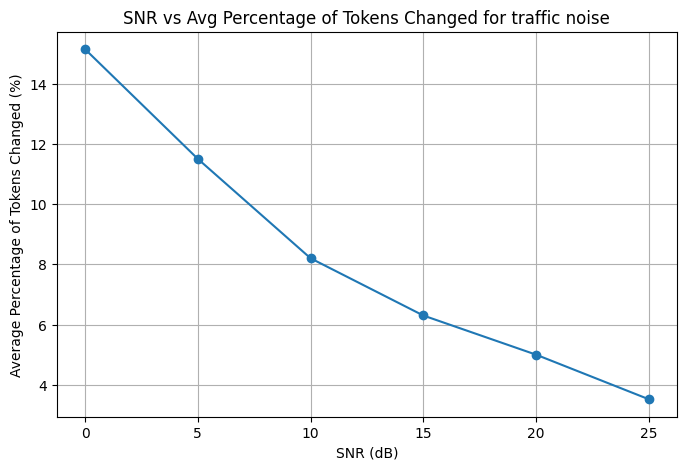

In [ ]:
import matplotlib.pyplot as plt

# Manually enter the SNR values and average percentages
snr_values = [0, 5, 10, 15, 20, 25]
average_percentages = [15.14, 11.5, 8.2, 6.3, 5, 3.52]  # Replace these values with your actual data

# Plotting the graph
plt.figure(figsize=(8, 5))
plt.plot(snr_values, average_percentages, marker='o', linestyle='-')
plt.title('SNR vs Avg Percentage of Tokens Changed for traffic noise')
plt.xlabel('SNR (dB)')
plt.ylabel('Average Percentage of Tokens Changed (%)')
plt.grid(True)
plt.xticks(snr_values)
plt.show()

In [ ]:
def process_single_snr_with_specifications(snr, files_subset, noise_file):
    print(f"\n--- SNR {snr} ---")

    total_percentage_changed = 0  # Initialize total percentage changed for this SNR

    snr_token_counts = 0
    snr_changed_token_counts = 0
    snr_noisy_token_counts = 0

    # Loop over selected audio files
    for file_path in files_subset:
        # Read clean audio
        clean_audio = read_audio(file_path)

        # Add noise to clean audio
        noisy_audio = add_noise(clean_audio, noise_file, snr)

        # Transcribe clean and noisy audio
        predicted_ids_clean = transcribe_audio(clean_audio)
        predicted_ids_noisy = transcribe_audio(noisy_audio)

        # Compare transcripts using the simplified function
        percentage_changed, total_tokens, num_differences, num_noisy_tokens = compare_transcripts(
            predicted_ids_clean.squeeze().numpy(), predicted_ids_noisy.squeeze().numpy())

        # Update total token count for this SNR
        snr_token_counts += total_tokens

        # Update total changed token count for this SNR
        snr_changed_token_counts += num_differences

        # Update total noisy token count for this SNR
        snr_noisy_token_counts += num_noisy_tokens

        # Print total number of clean tokens, number of tokens changed, percentage of tokens changed, and number of noisy tokens
        print(
            f"File: {file_path.split('/')[-1]}, Total clean tokens: {total_tokens}, Tokens changed: {num_differences}, Percentage changed: {percentage_changed:.2f}%, Noisy tokens: {num_noisy_tokens}")

    # Calculate the average percentage of tokens changed for this SNR
    average_percentage_changed_snr = (snr_changed_token_counts / snr_token_counts) * 100 if snr_token_counts > 0 else 0

    # Print the average percentage of tokens changed for this SNR
    print(
        f"Average percentage of tokens changed for SNR {snr}: {average_percentage_changed_snr:.2f}%")

    return snr, snr_token_counts, snr_changed_token_counts, snr_noisy_token_counts, average_percentage_changed_snr

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 0

# Randomly select a noise file
noise_file_path = "/content/Babble.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 0 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 45, Percentage changed: 15.20%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 39, Percentage changed: 24.68%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 41, Percentage changed: 20.40%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 143, Percentage changed: 33.89%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 70, Percentage changed: 28.11%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 21, Percentage changed: 10.82%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 106, Percentage changed: 31.45%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 21, Percentage changed: 13.64%, Noisy tokens: 154
File: 121-121726-0013.flac, Tot

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 5

# Randomly select a noise file
noise_file_path = "/content/Babble.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 5 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 39, Percentage changed: 13.18%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 30, Percentage changed: 18.99%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 24, Percentage changed: 11.94%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 62, Percentage changed: 14.69%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 23, Percentage changed: 9.24%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 21, Percentage changed: 10.82%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 55, Percentage changed: 16.32%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 21, Percentage changed: 13.64%, Noisy tokens: 154
File: 121-121726-0013.flac, Total 

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 10

# Randomly select a noise file
noise_file_path = "/content/Babble.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 10 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 28, Percentage changed: 9.46%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 30, Percentage changed: 18.99%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 12, Percentage changed: 5.97%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 50, Percentage changed: 11.85%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 17, Percentage changed: 6.83%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 10, Percentage changed: 5.15%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 40, Percentage changed: 11.87%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 18, Percentage changed: 11.69%, Noisy tokens: 154
File: 121-121726-0013.flac, Total cl

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 15

# Randomly select a noise file
noise_file_path = "/content/Babble.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 15 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 24, Percentage changed: 8.11%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 24, Percentage changed: 15.19%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 13, Percentage changed: 6.47%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 22, Percentage changed: 5.21%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 14, Percentage changed: 5.62%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 10, Percentage changed: 5.15%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 43, Percentage changed: 12.76%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 10, Percentage changed: 6.49%, Noisy tokens: 154
File: 121-121726-0013.flac, Total clea

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 20

# Randomly select a noise file
noise_file_path = "/content/Babble.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 20 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 22, Percentage changed: 7.43%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 14, Percentage changed: 8.86%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 10, Percentage changed: 4.98%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 20, Percentage changed: 4.74%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 16, Percentage changed: 6.43%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 7, Percentage changed: 3.61%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 31, Percentage changed: 9.20%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 12, Percentage changed: 7.79%, Noisy tokens: 154
File: 121-121726-0013.flac, Total clean t

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 25

# Randomly select a noise file
noise_file_path = "/content/Babble.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 25 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 21, Percentage changed: 7.09%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 10, Percentage changed: 6.33%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 9, Percentage changed: 4.48%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 19, Percentage changed: 4.50%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 6, Percentage changed: 2.41%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 8, Percentage changed: 4.12%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 29, Percentage changed: 8.61%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 8, Percentage changed: 5.19%, Noisy tokens: 154
File: 121-121726-0013.flac, Total clean toke

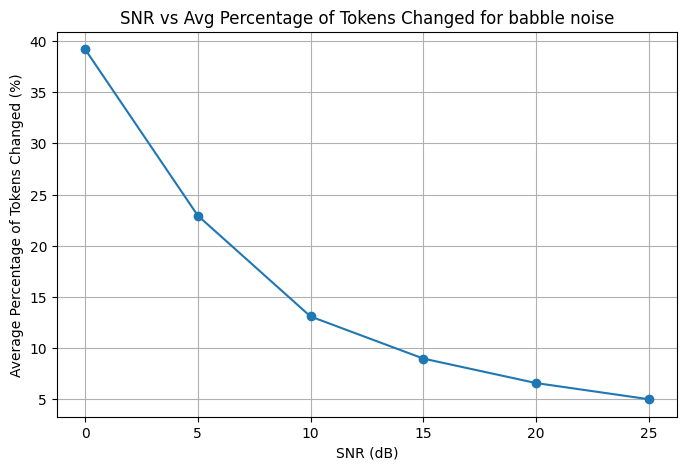

In [ ]:
import matplotlib.pyplot as plt

# Manually enter the SNR values and average percentages
snr_values = [0, 5, 10, 15, 20, 25]
average_percentages = [39.19, 22.94, 13.09, 8.98, 6.59, 5.01]  # Replace these values with your actual data

# Plotting the graph
plt.figure(figsize=(8, 5))
plt.plot(snr_values, average_percentages, marker='o', linestyle='-')
plt.title('SNR vs Avg Percentage of Tokens Changed for babble noise')
plt.xlabel('SNR (dB)')
plt.ylabel('Average Percentage of Tokens Changed (%)')
plt.grid(True)
plt.xticks(snr_values)
plt.show()

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 15

# Randomly select a noise file
noise_file_path = "/content/Cafeteria.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 15 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 26, Percentage changed: 8.78%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 9, Percentage changed: 5.70%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 14, Percentage changed: 6.97%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 28, Percentage changed: 6.64%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 18, Percentage changed: 7.23%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 16, Percentage changed: 8.25%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 27, Percentage changed: 8.01%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 8, Percentage changed: 5.19%, Noisy tokens: 154
File: 121-121726-0013.flac, Total clean to

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 0

# Randomly select a noise file
noise_file_path = "/content/Cafeteria.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 0 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 63, Percentage changed: 21.28%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 27, Percentage changed: 17.09%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 45, Percentage changed: 22.39%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 110, Percentage changed: 26.07%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 35, Percentage changed: 14.06%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 22, Percentage changed: 11.34%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 83, Percentage changed: 24.63%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 16, Percentage changed: 10.39%, Noisy tokens: 154
File: 121-121726-0013.flac, Tota

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 5

# Randomly select a noise file
noise_file_path = "/content/Cafeteria.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 5 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 30, Percentage changed: 10.14%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 24, Percentage changed: 15.19%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 21, Percentage changed: 10.45%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 76, Percentage changed: 18.01%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 32, Percentage changed: 12.85%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 16, Percentage changed: 8.25%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 46, Percentage changed: 13.65%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 19, Percentage changed: 12.34%, Noisy tokens: 154
File: 121-121726-0013.flac, Total 

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 10

# Randomly select a noise file
noise_file_path = "/content/Cafeteria.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 10 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 38, Percentage changed: 12.84%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 19, Percentage changed: 12.03%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 18, Percentage changed: 8.96%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 37, Percentage changed: 8.77%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 17, Percentage changed: 6.83%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 18, Percentage changed: 9.28%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 35, Percentage changed: 10.39%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 16, Percentage changed: 10.39%, Noisy tokens: 154
File: 121-121726-0013.flac, Total cl

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 20

# Randomly select a noise file
noise_file_path = "/content/Cafeteria.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 20 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 20, Percentage changed: 6.76%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 9, Percentage changed: 5.70%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 9, Percentage changed: 4.48%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 20, Percentage changed: 4.74%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 11, Percentage changed: 4.42%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 7, Percentage changed: 3.61%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 29, Percentage changed: 8.61%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 6, Percentage changed: 3.90%, Noisy tokens: 154
File: 121-121726-0013.flac, Total clean toke

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 25

# Randomly select a noise file
noise_file_path = "/content/Cafeteria.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 25 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 21, Percentage changed: 7.09%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 8, Percentage changed: 5.06%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 9, Percentage changed: 4.48%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 18, Percentage changed: 4.27%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 12, Percentage changed: 4.82%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 9, Percentage changed: 4.64%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 23, Percentage changed: 6.82%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 10, Percentage changed: 6.49%, Noisy tokens: 154
File: 121-121726-0013.flac, Total clean tok

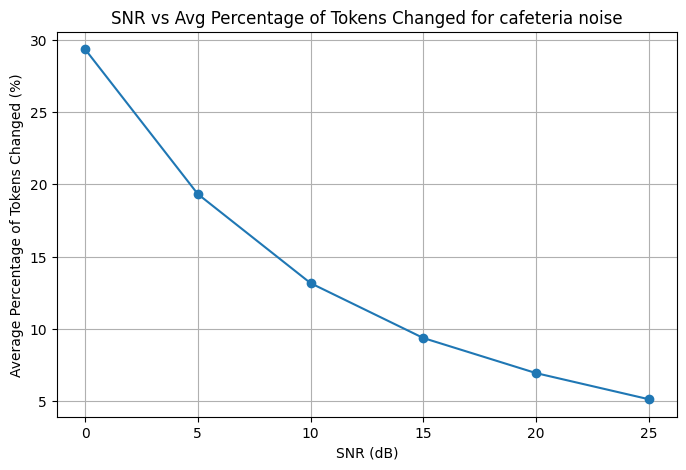

In [ ]:
import matplotlib.pyplot as plt

# Manually enter the SNR values and average percentages
snr_values = [0, 5, 10, 15, 20, 25]
average_percentages = [29.36, 19.33, 13.16, 9.36, 6.93, 5.12]  # Replace these values with your actual data

# Plotting the graph
plt.figure(figsize=(8, 5))
plt.plot(snr_values, average_percentages, marker='o', linestyle='-')
plt.title('SNR vs Avg Percentage of Tokens Changed for cafeteria noise')
plt.xlabel('SNR (dB)')
plt.ylabel('Average Percentage of Tokens Changed (%)')
plt.grid(True)
plt.xticks(snr_values)
plt.show()

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 0

# Randomly select a noise file
noise_file_path = "/content/Car.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 0 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 20, Percentage changed: 6.76%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 10, Percentage changed: 6.33%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 11, Percentage changed: 5.47%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 21, Percentage changed: 4.98%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 8, Percentage changed: 3.21%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 10, Percentage changed: 5.15%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 31, Percentage changed: 9.20%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 6, Percentage changed: 3.90%, Noisy tokens: 154
File: 121-121726-0013.flac, Total clean tok

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 5

# Randomly select a noise file
noise_file_path = "/content/Car.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 5 ---
File: 121-121726-0001.flac, Total clean tokens: 296, Tokens changed: 19, Percentage changed: 6.42%, Noisy tokens: 296
File: 121-121726-0014.flac, Total clean tokens: 158, Tokens changed: 8, Percentage changed: 5.06%, Noisy tokens: 158
File: 121-121726-0011.flac, Total clean tokens: 201, Tokens changed: 12, Percentage changed: 5.97%, Noisy tokens: 201
File: 121-121726-0000.flac, Total clean tokens: 422, Tokens changed: 16, Percentage changed: 3.79%, Noisy tokens: 422
File: 121-121726-0008.flac, Total clean tokens: 249, Tokens changed: 7, Percentage changed: 2.81%, Noisy tokens: 249
File: 121-121726-0006.flac, Total clean tokens: 194, Tokens changed: 9, Percentage changed: 4.64%, Noisy tokens: 194
File: 121-121726-0003.flac, Total clean tokens: 337, Tokens changed: 32, Percentage changed: 9.50%, Noisy tokens: 337
File: 121-121726-0005.flac, Total clean tokens: 154, Tokens changed: 10, Percentage changed: 6.49%, Noisy tokens: 154
File: 121-121726-0013.flac, Total clean toke

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 10

# Randomly select a noise file
noise_file_path = "/content/Car.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 10 ---
File: 4970-29095-0016.flac, Total clean tokens: 347, Tokens changed: 9, Percentage changed: 2.59%, Noisy tokens: 347
File: 4970-29095-0031.flac, Total clean tokens: 752, Tokens changed: 29, Percentage changed: 3.86%, Noisy tokens: 752
File: 4970-29095-0011.flac, Total clean tokens: 167, Tokens changed: 15, Percentage changed: 8.98%, Noisy tokens: 167
File: 4970-29095-0028.flac, Total clean tokens: 733, Tokens changed: 37, Percentage changed: 5.05%, Noisy tokens: 733
File: 4970-29095-0018.flac, Total clean tokens: 606, Tokens changed: 28, Percentage changed: 4.62%, Noisy tokens: 606
File: 4970-29095-0027.flac, Total clean tokens: 489, Tokens changed: 24, Percentage changed: 4.91%, Noisy tokens: 489
File: 4970-29095-0013.flac, Total clean tokens: 98, Tokens changed: 4, Percentage changed: 4.08%, Noisy tokens: 98
File: 4970-29095-0004.flac, Total clean tokens: 480, Tokens changed: 16, Percentage changed: 3.33%, Noisy tokens: 480
File: 4970-29095-0017.flac, Total clean toke

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 15

# Randomly select a noise file
noise_file_path = "/content/Car.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 15 ---
File: 4970-29095-0016.flac, Total clean tokens: 347, Tokens changed: 9, Percentage changed: 2.59%, Noisy tokens: 347
File: 4970-29095-0031.flac, Total clean tokens: 752, Tokens changed: 24, Percentage changed: 3.19%, Noisy tokens: 752
File: 4970-29095-0011.flac, Total clean tokens: 167, Tokens changed: 16, Percentage changed: 9.58%, Noisy tokens: 167
File: 4970-29095-0028.flac, Total clean tokens: 733, Tokens changed: 31, Percentage changed: 4.23%, Noisy tokens: 733
File: 4970-29095-0018.flac, Total clean tokens: 606, Tokens changed: 20, Percentage changed: 3.30%, Noisy tokens: 606
File: 4970-29095-0027.flac, Total clean tokens: 489, Tokens changed: 20, Percentage changed: 4.09%, Noisy tokens: 489
File: 4970-29095-0013.flac, Total clean tokens: 98, Tokens changed: 4, Percentage changed: 4.08%, Noisy tokens: 98
File: 4970-29095-0004.flac, Total clean tokens: 480, Tokens changed: 17, Percentage changed: 3.54%, Noisy tokens: 480
File: 4970-29095-0017.flac, Total clean toke

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 20

# Randomly select a noise file
noise_file_path = "/content/Car.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 20 ---
File: 4970-29095-0016.flac, Total clean tokens: 347, Tokens changed: 9, Percentage changed: 2.59%, Noisy tokens: 347
File: 4970-29095-0031.flac, Total clean tokens: 752, Tokens changed: 26, Percentage changed: 3.46%, Noisy tokens: 752
File: 4970-29095-0011.flac, Total clean tokens: 167, Tokens changed: 12, Percentage changed: 7.19%, Noisy tokens: 167
File: 4970-29095-0028.flac, Total clean tokens: 733, Tokens changed: 20, Percentage changed: 2.73%, Noisy tokens: 733
File: 4970-29095-0018.flac, Total clean tokens: 606, Tokens changed: 23, Percentage changed: 3.80%, Noisy tokens: 606
File: 4970-29095-0027.flac, Total clean tokens: 489, Tokens changed: 22, Percentage changed: 4.50%, Noisy tokens: 489
File: 4970-29095-0013.flac, Total clean tokens: 98, Tokens changed: 4, Percentage changed: 4.08%, Noisy tokens: 98
File: 4970-29095-0004.flac, Total clean tokens: 480, Tokens changed: 16, Percentage changed: 3.33%, Noisy tokens: 480
File: 4970-29095-0017.flac, Total clean toke

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 25

# Randomly select a noise file
noise_file_path = "/content/Car.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 25 ---
File: 4970-29095-0016.flac, Total clean tokens: 347, Tokens changed: 9, Percentage changed: 2.59%, Noisy tokens: 347
File: 4970-29095-0031.flac, Total clean tokens: 752, Tokens changed: 24, Percentage changed: 3.19%, Noisy tokens: 752
File: 4970-29095-0011.flac, Total clean tokens: 167, Tokens changed: 6, Percentage changed: 3.59%, Noisy tokens: 167
File: 4970-29095-0028.flac, Total clean tokens: 733, Tokens changed: 16, Percentage changed: 2.18%, Noisy tokens: 733
File: 4970-29095-0018.flac, Total clean tokens: 606, Tokens changed: 17, Percentage changed: 2.81%, Noisy tokens: 606
File: 4970-29095-0027.flac, Total clean tokens: 489, Tokens changed: 12, Percentage changed: 2.45%, Noisy tokens: 489
File: 4970-29095-0013.flac, Total clean tokens: 98, Tokens changed: 3, Percentage changed: 3.06%, Noisy tokens: 98
File: 4970-29095-0004.flac, Total clean tokens: 480, Tokens changed: 10, Percentage changed: 2.08%, Noisy tokens: 480
File: 4970-29095-0017.flac, Total clean token

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 0

# Randomly select a noise file
noise_file_path = "/content/Livingroom.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 0 ---
File: 1188-133604-0022.flac, Total clean tokens: 481, Tokens changed: 86, Percentage changed: 17.88%, Noisy tokens: 481
File: 1188-133604-0004.flac, Total clean tokens: 532, Tokens changed: 115, Percentage changed: 21.62%, Noisy tokens: 532
File: 1188-133604-0030.flac, Total clean tokens: 95, Tokens changed: 14, Percentage changed: 14.74%, Noisy tokens: 95
File: 1188-133604-0016.flac, Total clean tokens: 829, Tokens changed: 151, Percentage changed: 18.21%, Noisy tokens: 829
File: 1188-133604-0025.flac, Total clean tokens: 372, Tokens changed: 108, Percentage changed: 29.03%, Noisy tokens: 372
File: 1188-133604-0039.flac, Total clean tokens: 331, Tokens changed: 44, Percentage changed: 13.29%, Noisy tokens: 331
File: 1188-133604-0035.flac, Total clean tokens: 146, Tokens changed: 26, Percentage changed: 17.81%, Noisy tokens: 146
File: 1188-133604-0023.flac, Total clean tokens: 1183, Tokens changed: 212, Percentage changed: 17.92%, Noisy tokens: 1183
File: 1188-133604-000

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 5

# Randomly select a noise file
noise_file_path = "/content/Livingroom.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 5 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 31, Percentage changed: 13.08%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 253, Percentage changed: 17.82%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 69, Percentage changed: 30.40%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 104, Percentage changed: 15.78%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 28, Percentage changed: 8.70%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 25, Percentage changed: 15.24%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 17, Percentage changed: 12.06%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 67, Percentage changed: 24.63%, Noisy tokens: 272
File: 4992-41797-0012.flac, To

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 10

# Randomly select a noise file
noise_file_path = "/content/Livingroom.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 15

# Randomly select a noise file
noise_file_path = "/content/Livingroom.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 20

# Randomly select a noise file
noise_file_path = "/content/Livingroom.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 25

# Randomly select a noise file
noise_file_path = "/content/Livingroom.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 25 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 30, Percentage changed: 12.66%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 68, Percentage changed: 4.79%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 18, Percentage changed: 7.93%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 24, Percentage changed: 3.64%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 11, Percentage changed: 3.42%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 11, Percentage changed: 6.71%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 5, Percentage changed: 3.55%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 20, Percentage changed: 7.35%, Noisy tokens: 272
File: 4992-41797-0012.flac, Total clea

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 0

# Randomly select a noise file
noise_file_path = "/content/Shopping.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 5

# Randomly select a noise file
noise_file_path = "/content/Shopping.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 5 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 29, Percentage changed: 12.24%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 249, Percentage changed: 17.54%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 37, Percentage changed: 16.30%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 92, Percentage changed: 13.96%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 32, Percentage changed: 9.94%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 38, Percentage changed: 23.17%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 21, Percentage changed: 14.89%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 47, Percentage changed: 17.28%, Noisy tokens: 272
File: 4992-41797-0012.flac, Tot

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 10

# Randomly select a noise file
noise_file_path = "/content/Shopping.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 10 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 34, Percentage changed: 14.35%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 207, Percentage changed: 14.58%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 48, Percentage changed: 21.15%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 62, Percentage changed: 9.41%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 27, Percentage changed: 8.39%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 25, Percentage changed: 15.24%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 15, Percentage changed: 10.64%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 42, Percentage changed: 15.44%, Noisy tokens: 272
File: 4992-41797-0012.flac, Tot

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 15

# Randomly select a noise file
noise_file_path = "/content/Shopping.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 15 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 19, Percentage changed: 8.02%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 142, Percentage changed: 10.00%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 21, Percentage changed: 9.25%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 55, Percentage changed: 8.35%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 23, Percentage changed: 7.14%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 25, Percentage changed: 15.24%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 16, Percentage changed: 11.35%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 34, Percentage changed: 12.50%, Noisy tokens: 272
File: 4992-41797-0012.flac, Total

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 20

# Randomly select a noise file
noise_file_path = "/content/Shopping.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 20 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 24, Percentage changed: 10.13%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 124, Percentage changed: 8.73%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 34, Percentage changed: 14.98%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 30, Percentage changed: 4.55%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 10, Percentage changed: 3.11%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 16, Percentage changed: 9.76%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 10, Percentage changed: 7.09%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 24, Percentage changed: 8.82%, Noisy tokens: 272
File: 4992-41797-0012.flac, Total c

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 25

# Randomly select a noise file
noise_file_path = "/content/Shopping.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 25 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 14, Percentage changed: 5.91%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 64, Percentage changed: 4.51%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 19, Percentage changed: 8.37%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 19, Percentage changed: 2.88%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 12, Percentage changed: 3.73%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 14, Percentage changed: 8.54%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 8, Percentage changed: 5.67%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 17, Percentage changed: 6.25%, Noisy tokens: 272
File: 4992-41797-0012.flac, Total clean

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 0

# Randomly select a noise file
noise_file_path = "/content/Train_Station.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 5

# Randomly select a noise file
noise_file_path = "/content/Train_Station.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 10

# Randomly select a noise file
noise_file_path = "/content/Train_Station.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 15

# Randomly select a noise file
noise_file_path = "/content/Train_Station.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 15 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 9, Percentage changed: 3.80%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 84, Percentage changed: 5.92%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 17, Percentage changed: 7.49%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 25, Percentage changed: 3.79%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 15, Percentage changed: 4.66%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 14, Percentage changed: 8.54%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 5, Percentage changed: 3.55%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 34, Percentage changed: 12.50%, Noisy tokens: 272
File: 4992-41797-0012.flac, Total clean

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 20

# Randomly select a noise file
noise_file_path = "/content/Train_Station.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)


# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 20 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 7, Percentage changed: 2.95%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 78, Percentage changed: 5.49%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 17, Percentage changed: 7.49%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 25, Percentage changed: 3.79%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 15, Percentage changed: 4.66%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 7, Percentage changed: 4.27%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 7, Percentage changed: 4.96%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 18, Percentage changed: 6.62%, Noisy tokens: 272
File: 4992-41797-0012.flac, Total clean t

In [ ]:
# Select the first 1000 files
flac_files_subsets = flac_files[:1000]

# Specify the SNR value to process
snr_to_process = 25

# Randomly select a noise file
noise_file_path = "/content/Train_Station.wav"

# Read the noise file
noise_data = read_audio(noise_file_path)

# Call the function with specifications
snr_result = process_single_snr_with_specifications(snr_to_process, flac_files_subsets, noise_data)

# Print the result
print(snr_result)


--- SNR 25 ---
File: 4992-41797-0019.flac, Total clean tokens: 237, Tokens changed: 9, Percentage changed: 3.80%, Noisy tokens: 237
File: 4992-41797-0001.flac, Total clean tokens: 1420, Tokens changed: 60, Percentage changed: 4.23%, Noisy tokens: 1420
File: 4992-41797-0006.flac, Total clean tokens: 227, Tokens changed: 13, Percentage changed: 5.73%, Noisy tokens: 227
File: 4992-41797-0009.flac, Total clean tokens: 659, Tokens changed: 14, Percentage changed: 2.12%, Noisy tokens: 659
File: 4992-41797-0022.flac, Total clean tokens: 322, Tokens changed: 7, Percentage changed: 2.17%, Noisy tokens: 322
File: 4992-41797-0016.flac, Total clean tokens: 164, Tokens changed: 6, Percentage changed: 3.66%, Noisy tokens: 164
File: 4992-41797-0003.flac, Total clean tokens: 141, Tokens changed: 4, Percentage changed: 2.84%, Noisy tokens: 141
File: 4992-41797-0011.flac, Total clean tokens: 272, Tokens changed: 14, Percentage changed: 5.15%, Noisy tokens: 272
File: 4992-41797-0012.flac, Total clean to